### Imports

In [1]:
import re
import pandas as pd
from wordcloud import WordCloud
import nltk
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split

### Função auxiliar de limpeza

In [2]:
def clean(text):
    text = text.lower()
    text = re.sub(
        r"https?:\/\/(www\.)? ?[-a-zA-Z0-9@:%._\+~#=]{1,256}\. ?[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)",
        "",
        text,
    )
    text = re.sub(r"(it | he | she | that)'?s", '\1 is', text)
    text = re.sub(r"(they | we | you)'re", '\1 are', text)
    text = re.sub(r"(they | we | you)'?ve", '\1 have', text)
    text = re.sub(r"this'", 'this is', text)
    text = re.sub(r"http", ' ', text)
    text = re.sub(r"html", ' ', text)
    text = re.sub(r"didn'?t", 'did not', text)
    text = re.sub(r"don'?t", 'do not', text)
    text = re.sub(r"don'?t", 'do not', text)
    text = re.sub(r"can'?t", 'cannot', text)
    text = re.sub(r"&.+;", ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

Lendo o dataset e aplicando a limpeza

In [3]:
df = pd.read_csv('irony-labeled.csv')
df['comment_text'] = df['comment_text'].apply(clean)
df.tail(3)

,comment_text,label
1946,[... what? ](,-1
1947,does anybody remember during one of the debate...,-1
1948,the pope is meeting a cruel dictator. likely w...,1


In [4]:
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')
STOPWORDS = set(STOPWORDS)

### WordClouds

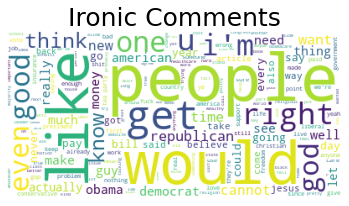

In [5]:
text_ironic = ' '.join(df.comment_text[df['label'] == 1])
wc_ironic = WordCloud(background_color='white',stopwords=STOPWORDS).generate(text_ironic)
plt.imshow(wc_ironic)
plt.axis('off')
plt.title('Ironic Comments',fontsize=25)
plt.show()

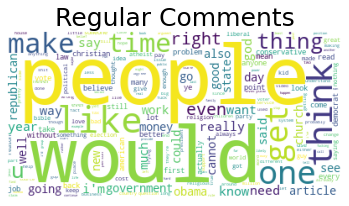

In [6]:
text = ' '.join(df.comment_text[df['label'] == -1])
wc = WordCloud(background_color='white',stopwords=STOPWORDS).generate(text)
plt.imshow(wc)
plt.axis('off')
plt.title('Regular Comments',fontsize=25)
plt.show()

Função auxiliar de pré-processamento dos textos (retirados da aula):

In [7]:
def preprocess(sent):
    def convert(word):
        word = re.sub(r"\W+", "", word)
        # Verifica se é um número.
        try:
            _ = float(word)
            return '<num>'
        except:
            pass

        # Verifica se é uma palavra.
        if word.isalpha():
            lower = word.lower()
            return '<stop>' if lower in STOPWORDS else lower

        # Caso contrário, é pontuação ou estranho.
        return '<weird>'

    processed = [convert(word) for word in sent]
    forbidden_words = set(('<num>', '<stop>', '<weird>'))
    return [word for word in processed if word not in forbidden_words]

Obtendo as sentenças pré-processadas:

In [8]:
sents_all = [preprocess(item.strip().split()) for item in df.comment_text]
df['word_list'] = sents_all
df.head(3)

,comment_text,label,word_list
0,i suspect atheists are projecting their desire...,-1,"[suspect, atheists, projecting, desires, imagi..."
1,it's funny how the arguments the shills are ma...,-1,"[funny, arguments, shills, making, still, clos..."
2,we are truly following the patterns of how the...,-1,"[truly, following, patterns, mandarins, took, ..."


Contagem simples das palavras mais frequentes em cada uma das categorias.
    
- o valor de `r` pode ser modificado para observar outro range de palavras (mais frequentes `r=0`)

In [9]:
from collections import defaultdict
word_counts_ironic = defaultdict(lambda: 0)
word_counts_non_ironic = defaultdict(lambda: 0)

for i in range(len(df)):
    if df['label'][i] == 1:
        for j in df['word_list'][i]:
            word_counts_ironic[j] += 1 
    else:
        for j in df['word_list'][i]:
            word_counts_non_ironic[j] += 1
    
word_counts_ironic_sorted = sorted(word_counts_ironic.items(), key=lambda k: k[1], reverse=True)
word_counts_non_ironic_sorted = sorted(word_counts_non_ironic.items(), key=lambda k: k[1], reverse=True)

print("Most common words in ironic texts")
r = 30
k = 10
for i in range(k):
    print(word_counts_ironic_sorted[i+r])
print("=" * 80)
print("Most common words in non ironic texts")
for i in range(k):
    print(word_counts_non_ironic_sorted[i+r])

Most common words in ironic texts
('hes', 18)
('bill', 18)
('doesnt', 18)
('every', 18)
('thing', 18)
('got', 17)
('american', 17)
('take', 17)
('pay', 17)
('republicans', 17)
Most common words in non ironic texts
('party', 77)
('years', 77)
('said', 75)
('things', 73)
('isnt', 71)
('need', 70)
('go', 69)
('church', 68)
('work', 67)
('many', 67)


### LDA

In [10]:
from gensim.corpora import Dictionary
import gensim
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

c:\users\mathe\appdata\local\programs\python\python38\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [11]:
#Generate LDA MODEL
from gensim.models.ldamulticore import LdaMulticore
def model_dict(sents, NUM_TOPICS, alpha='symmetric', eta='symmetric'):
    dictionary = Dictionary(sents)
    corpus = [dictionary.doc2bow(sent) for sent in sents]

    ldamodel = LdaMulticore(corpus, num_topics=NUM_TOPICS, id2word=dictionary, random_state=100, alpha=alpha, eta=eta, iterations=25, passes=10)

    return corpus, dictionary, ldamodel

In [12]:
#Check topics
def check_topics(corpus, lda_model):
    topics = lda_model.get_document_topics(corpus, per_word_topics=True)


    doc_topics, word_topics, phi_values = topics[10]
    print('Document topic:', doc_topics, "\n")

    for topic, strength in doc_topics:
        print(f'Topico: {topic}')
        print(lda_model.print_topic(topic, topn=20))

    topics = lda_model.print_topics(num_words=10)
    for topic in topics:
        print(topic)

In [13]:
def display_model(corpus, dictionary, ldamodel):  
    lda_display = pyLDAvis.gensim_models.prepare(
        ldamodel,
        corpus,
        dictionary,
        sort_topics=False,
    )
    return pyLDAvis.display(lda_display)

## Modelo de 2 tópicos

In [14]:
corpus_all, dictionary_all, lda_model_all = model_dict(sents_all, NUM_TOPICS=2)
# check_topics(corpus_all, lda_model_all)

In [15]:
display_model(corpus_all, dictionary_all, lda_model_all)

Função auxiliar usada para determinar qual o tópico dominante de cada um dos documentos (retirado e adaptado de https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/): 

In [16]:
#Dominant topic in each sentence
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()

    # obtem principal topico por documento
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, _) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

In [17]:
df_topic_sents_keywords = format_topics_sentences(lda_model_all, corpus_all, sents_all)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Keywords', 'Text']

# verifica se o df está na mesma ordem que o original, para podermos atribuir correntamente as labels
df_dominant_topic['label'] = df['label']
df_dominant_topic['check'] = df['word_list'] == df_dominant_topic['Text']

df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Keywords,Text,label,check
0,0,0.0,"like, people, would, think, get, im, one, time...","[suspect, atheists, projecting, desires, imagi...",-1,True
1,1,1.0,"people, would, like, one, make, us, right, mon...","[funny, arguments, shills, making, still, clos...",-1,True
2,2,0.0,"like, people, would, think, get, im, one, time...","[truly, following, patterns, mandarins, took, ...",-1,True
3,3,1.0,"people, would, like, one, make, us, right, mon...","[air, pressure, dropping, altitude, goes, high...",-1,True
4,4,0.0,"like, people, would, think, get, im, one, time...","[absolutely, think, wed, hard, pressed, find, ...",-1,True


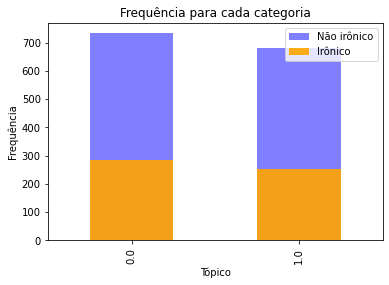

In [18]:
ironic = df_dominant_topic[df_dominant_topic['label'] == 1]
nonIronic = df_dominant_topic[df_dominant_topic['label'] == -1]

fig, ax = plt.subplots()
nonIronic['Dominant_Topic'].value_counts().sort_index().plot(kind='bar', color='b', label='Não irônico', alpha=0.5)
ironic['Dominant_Topic'].value_counts().sort_index().plot(kind='bar', color='orange', label='Irônico', alpha=0.9)
plt.ylabel('Frequência')
plt.xlabel('Tópico')
plt.legend()
plt.title("Frequência para cada categoria")
plt.show()

In [19]:
countNonIronic = nonIronic['Dominant_Topic'].value_counts().sort_index()
countIronic = ironic['Dominant_Topic'].value_counts().sort_index()

ironicPercentage = countIronic/(countIronic + countNonIronic) * 100

ironicPercentage.rename_axis('Tópicos').to_frame('Porcentagem de documentos irônicos por tópico')

,Porcentagem de documentos irônicos por tópico
Tópicos,
0.0,27.996071
1.0,27.067669


## Modelo de 3 tópicos

In [20]:
corpus_all, dictionary_all, lda_model_all = model_dict(sents_all, NUM_TOPICS=3)
display_model(corpus_all, dictionary_all, lda_model_all)

In [21]:
df_topic_sents_keywords = format_topics_sentences(lda_model_all, corpus_all, sents_all)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Keywords', 'Text']

df_dominant_topic['label'] = df['label']
df_dominant_topic['check'] = df['word_list'] == df_dominant_topic['Text']

df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Keywords,Text,label,check
0,0,1.0,"people, would, like, money, one, make, get, go...","[suspect, atheists, projecting, desires, imagi...",-1,True
1,1,1.0,"people, would, like, money, one, make, get, go...","[funny, arguments, shills, making, still, clos...",-1,True
2,2,0.0,"think, get, would, people, like, time, see, im...","[truly, following, patterns, mandarins, took, ...",-1,True
3,3,1.0,"people, would, like, money, one, make, get, go...","[air, pressure, dropping, altitude, goes, high...",-1,True
4,4,0.0,"think, get, would, people, like, time, see, im...","[absolutely, think, wed, hard, pressed, find, ...",-1,True


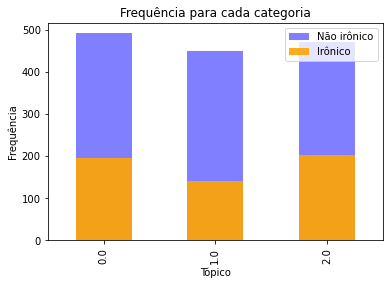

In [22]:
ironic = df_dominant_topic[df_dominant_topic['label'] == 1]
nonIronic = df_dominant_topic[df_dominant_topic['label'] == -1]

fig, ax = plt.subplots()
nonIronic['Dominant_Topic'].value_counts().sort_index().plot(kind='bar', color='b', label='Não irônico', alpha=0.5)
ironic['Dominant_Topic'].value_counts().sort_index().plot(kind='bar', color='orange', label='Irônico', alpha=0.9)
plt.ylabel('Frequência')
plt.xlabel('Tópico')
plt.legend()
plt.title("Frequência para cada categoria")
plt.show()

In [23]:
countNonIronic = nonIronic['Dominant_Topic'].value_counts().sort_index()
countIronic = ironic['Dominant_Topic'].value_counts().sort_index()

ironicPercentage = countIronic/(countIronic + countNonIronic) * 100

ironicPercentage.rename_axis('Tópicos').to_frame('Porcentagem de documentos irônicos por tópico')

,Porcentagem de documentos irônicos por tópico
Tópicos,
0.0,28.384279
1.0,23.769100
2.0,30.014859
